## ADS 509 Module 3: Group Comparison

In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Calculate the number of tokens
    num_tokens = len(tokens)

    # Calculate the number of unique tokens
    num_unique_tokens = len(set(tokens))

    # Calculate the number of characters
    num_characters = sum(len(token) for token in tokens)

    # Calculate lexical diversity
    lexical_diversity = num_unique_tokens / num_tokens

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # Display the most common tokens
        common_tokens = Counter(tokens).most_common(num_tokens)
        print(f"The {num_tokens} most common tokens are:")
        for token, count in common_tokens:
            print(f"{token}: {count} times")
    
    return(0)


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens
   
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    tokens = text.split()
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data Ingestion

In [3]:
data_location = "/users/kayan/Desktop/M1_Results/"

twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [4]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [5]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [6]:
data_location = "/users/kayan/Desktop/M1_Results/"
lyrics_folder = "lyrics/"
cher_folder = "cher/"
robyn_folder = "robyn/"

def read_artist_data(artist_folder, artist_name):
    artist_data = pd.DataFrame()
    for filename in os.listdir(data_location + lyrics_folder + artist_folder):
        if filename.endswith(".txt"):
            file_path = os.path.join(data_location, lyrics_folder, artist_folder, filename)
            data = pd.read_csv(file_path, sep="\t", quoting=3)
            data['artist'] = artist_name
            artist_data = pd.concat([artist_data, data], ignore_index=True)
    return artist_data

cher_data = read_artist_data(cher_folder, "cher")
robyn_data = read_artist_data(robyn_folder, "robyn")

lyrics_data = pd.concat([cher_data, robyn_data], ignore_index=True)

# Remove the variables to free up memory
del cher_data, robyn_data


In [7]:
lyrics_columns = lyrics_data.columns[1:]

# Concatenate lyrics columns into a new column named "lyrics"
lyrics_data["lyrics"] = lyrics_data[lyrics_columns].apply(lambda row: ' '.join(row.dropna()), axis=1)

## Tokenization and Normalization

In [13]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

stop_words = set(stopwords.words('english'))

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Assuming "lyrics" is a column containing the lyrics in your DataFrame
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

In [14]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

In [15]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
506706,cher,• #gemini ♊️ • L❤️VE all things Cleveland ⚾️ •...,"[•, , #, g, e, n, , ♊, ️, , •, , l, ❤, ️, ..."
3758324,cher,I am a full time Mommy of 2 sons Lukas & Jakob...,"[ , , , f, u, l, l, , e, , , f, , 2, , ..."
538621,cher,One life go ! ⏳,"[n, e, , l, f, e, , g, , , ⏳]"
21895,cher,tangina nyaw😌 #RosasAngKulayNgBukas 💕,"[n, g, n, , n, w, 😌, , #, r, n, g, k, u, l, ..."
212659,cher,"If I see a 🐈🐈‍⬛, I’m probably gonna tweet abou...","[f, , , e, e, , , 🐈, 🐈, ‍, ⬛, , ’, , p, ..."
744464,cher,“I can't control the wind but I can adjust the...,"[“, , c, n, , c, n, r, l, , h, e, , w, n, ..."
53201,cher,Louis beastars 🥴😘,"[l, u, , b, e, r, , 🥴, 😘]"
530216,cher,Assistant Directing is my job. Cheese is my li...,"[n, , r, e, c, n, g, , , , j, b, , c, h, ..."
318933,robyn,No lives matter until Black Lives Matter.🫀❤️‍🔥♥️,"[n, , l, v, e, , e, r, , u, n, l, , b, l, ..."
3737624,cher,🦋Positive Vibin| Makeup Lovin | Dance Stunnin ...,"[🦋, p, v, e, , v, b, n, , k, e, u, p, , l, ..."


Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A:For social media content, hashtags and usernames are commonly used. It might be beneficial to have a tokenization strategy that keeps these elements intact for better interpretation of the context.

## Calculate descriptive statistics on the two sets of lyrics and compare the results

In [21]:
from collections import Counter

def find_unique_tokens(corpus_data, n=5, top_k=10):
    # Check if 'artist' column exists in corpus_data
    if 'artist' not in corpus_data.columns:
        raise ValueError("The 'artist' column is missing in the provided dataset.")

    # Create a Counter for each corpus
    counters = {artist: Counter() for artist in corpus_data['artist'].unique()}

    # Count occurrences of each token in each corpus
    for index, row in corpus_data.iterrows():
        tokens = row['tokens']
        counters[row['artist']] += Counter(tokens)

    unique_tokens = []

    # Calculate concentration ratios and filter tokens
    for token in counters[list(counters.keys())[0]]:
        total_counts = sum(counts.get(token, 0) for counts in counters.values())
        if total_counts >= n:
            ratios = {artist: counters[artist][token] / total_counts for artist in counters.keys()}
            max_ratio_artist = max(ratios, key=ratios.get)
            max_ratio = ratios[max_ratio_artist]

            # Append token to the list if it's in the top_k for the highest ratio
            if sum(1 for ratio in ratios.values() if ratio == max_ratio) <= top_k:
                unique_tokens.append((token, max_ratio_artist, max_ratio))

    # Sort the tokens by their concentration ratio in descending order
    unique_tokens.sort(key=lambda x: x[2], reverse=True)

    return unique_tokens[:top_k]

# Find unique tokens for each corpus
unique_tokens_cher = find_unique_tokens(lyrics_data[lyrics_data['artist'] == 'cher'], n=5)
unique_tokens_robyn = find_unique_tokens(lyrics_data[lyrics_data['artist'] == 'robyn'], n=5)
unique_tokens_twitter_cher = find_unique_tokens(twitter_data[twitter_data['artist'] == 'cher'], n=5)
unique_tokens_twitter_robyn = find_unique_tokens(twitter_data[twitter_data['artist'] == 'robyn'], n=5)

# Print the results
print("Unique Tokens for Cher's Lyrics:")
print(unique_tokens_cher)
print("\nUnique Tokens for Robyn's Lyrics:")
print(unique_tokens_robyn)
print("\nUnique Tokens for Cher's Twitter Descriptions:")
print(unique_tokens_twitter_cher)
print("\nUnique Tokens for Robyn's Twitter Descriptions:")
print(unique_tokens_twitter_robyn)

Unique Tokens for Cher's Lyrics:
[('c', 'cher', 1.0), ('h', 'cher', 1.0), ('e', 'cher', 1.0), ('r', 'cher', 1.0), (' ', 'cher', 1.0), ('l', 'cher', 1.0), ('n', 'cher', 1.0), ('w', 'cher', 1.0), ('u', 'cher', 1.0), ('b', 'cher', 1.0)]

Unique Tokens for Robyn's Lyrics:
[('r', 'robyn', 1.0), ('b', 'robyn', 1.0), ('n', 'robyn', 1.0), (' ', 'robyn', 1.0), ('e', 'robyn', 1.0), ('l', 'robyn', 1.0), ('v', 'robyn', 1.0), ('p', 'robyn', 1.0), ('j', 'robyn', 1.0), ('u', 'robyn', 1.0)]

Unique Tokens for Cher's Twitter Descriptions:
[('n', 'cher', 1.0), ('𝙿', 'cher', 1.0), ('𝚛', 'cher', 1.0), ('𝚘', 'cher', 1.0), ('𝚞', 'cher', 1.0), ('𝚍', 'cher', 1.0), (' ', 'cher', 1.0), ('𝚜', 'cher', 1.0), ('𝚙', 'cher', 1.0), ('𝚝', 'cher', 1.0)]

Unique Tokens for Robyn's Twitter Descriptions:
[(' ', 'robyn', 1.0), ('l', 'robyn', 1.0), ('v', 'robyn', 1.0), ('e', 'robyn', 1.0), ('c', 'robyn', 1.0), ('h', 'robyn', 1.0), ('•', 'robyn', 1.0), ('f', 'robyn', 1.0), ('b', 'robyn', 1.0), ('k', 'robyn', 1.0)]


Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A:For the lyrics part, the top tokens is the artist name.

## Build word clouds for all four corpora.

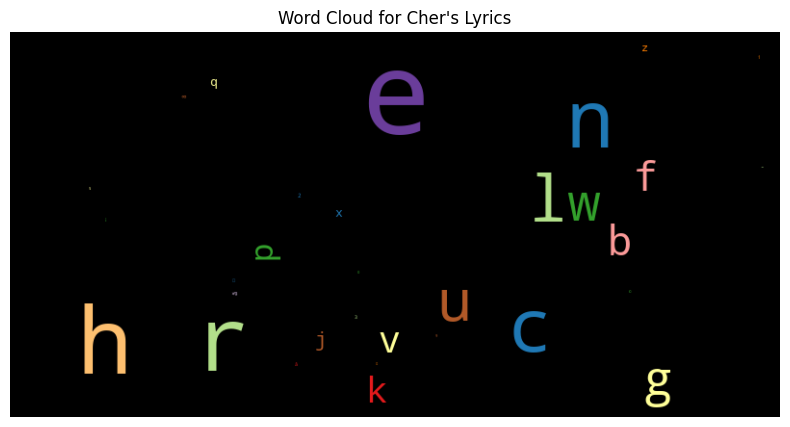

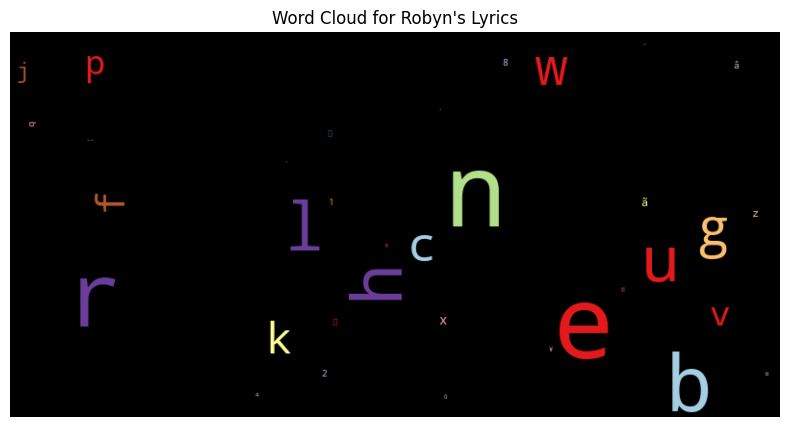

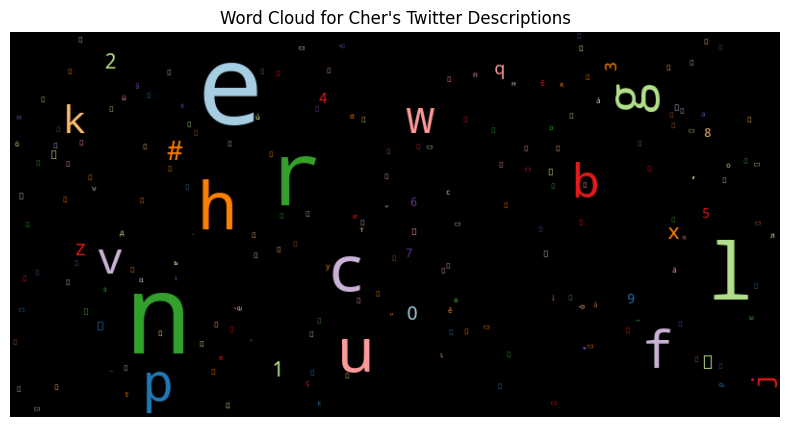

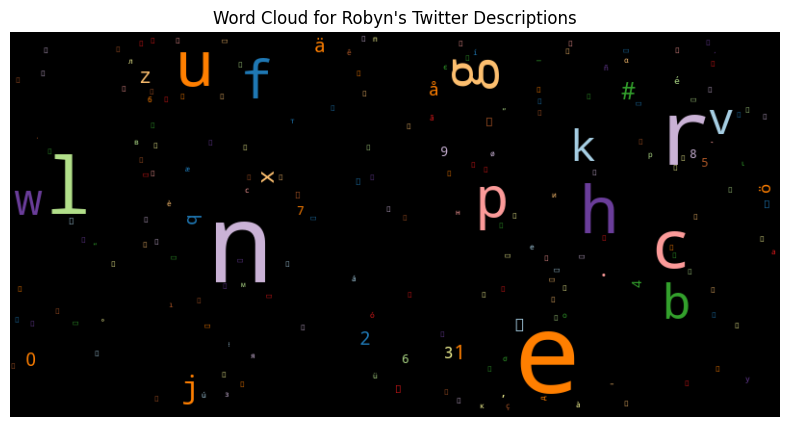

In [24]:
from matplotlib import pyplot as plt

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    counter = Counter()
    df[column].map(update)

    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

# Function to generate word clouds
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, background_color="black", colormap="Paired", max_font_size=150, max_words=max_words)

    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

    wc.generate_from_frequencies(counter)

    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Define stopwords if needed
stopwords = set()

# Count words and generate word clouds for each corpus
freq_df_cher_lyrics = count_words(lyrics_data[lyrics_data['artist'] == 'cher'])
wordcloud(freq_df_cher_lyrics['freq'], title="Word Cloud for Cher's Lyrics", stopwords=stopwords)

freq_df_robyn_lyrics = count_words(lyrics_data[lyrics_data['artist'] == 'robyn'])
wordcloud(freq_df_robyn_lyrics['freq'], title="Word Cloud for Robyn's Lyrics", stopwords=stopwords)

freq_df_cher_twitter = count_words(twitter_data[twitter_data['artist'] == 'cher'])
wordcloud(freq_df_cher_twitter['freq'], title="Word Cloud for Cher's Twitter Descriptions", stopwords=stopwords)

freq_df_robyn_twitter = count_words(twitter_data[twitter_data['artist'] == 'robyn'])
wordcloud(freq_df_robyn_twitter['freq'], title="Word Cloud for Robyn's Twitter Descriptions", stopwords=stopwords)

Q: What observations do you have about these (relatively straightforward) wordclouds?

A: Some of the top words are the same in four corporas, like n, e, h and r.